In [2]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
import graph_tool.all as gt

In [3]:
sns.set_context("talk")

### 1. Data Preparation

In [4]:
from scipy.io import loadmat

In [5]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/ZConnectome_04292021.mat"
somalocation = loadmat(data_path) 

In [6]:
somalocation['ZConnectome'].dtype

dtype([('cellID', 'O'), ('cellType', 'O'), ('origin', 'O'), ('inVol', 'O'), ('treeLength', 'O'), ('isExistRoot', 'O'), ('connectome', 'O'), ('readme', 'O')])

In [7]:
cell_loc = dict(zip(somalocation['ZConnectome']['cellID'][0][0][:,0], 
                    somalocation['ZConnectome']['origin'][0][0]))

In [8]:
modO = gt.load_graph("saved/gt-ax50-dd100-modO-sg.xml.gz")

In [9]:
# modO.save("saved/gt-ax50-dd100-modO-sg.xml.gz")

### 2. Soma Distribution

In [70]:
def plot_soma(locs):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    for loc in locs:
        (x, y, z) = loc
#         ax.scatter(x, y, z, c='gray', marker='^', alpha=0.8)
        ax.scatter(z, x, y, c='#D8545D', marker='o', alpha=0.8)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.set_xlabel('   z (μm)', fontsize=16)
    ax.set_ylabel('x (μm)', fontsize=16)
    ax.set_zlabel('y (μm)', fontsize=16)

    ax.view_init(-160, -20)

    plt.show()

218


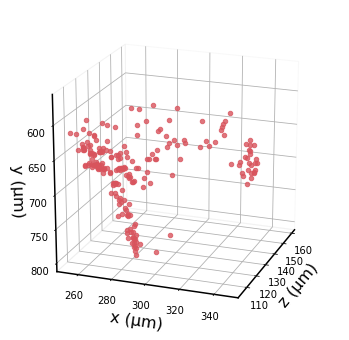

In [71]:
modO_cell_ids = [modO.vp['cellid'][v] for v in modO.vertices()]
modO_soma_loc = [cell_loc[v] for v in modO_cell_ids if v in cell_loc.keys()]
print(len(modO_soma_loc))
plot_soma(modO_soma_loc)

In [74]:
def plot_soma_rel(prelocs, postlocs):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    for loc in prelocs:
        (x, y, z) = loc
        ax.scatter(z, x, y, c='#5461D8', marker='o', alpha=0.7)

    for loc in postlocs:
        (x, y, z) = loc
        ax.scatter(z, x, y, c='#D8545D', marker='^', alpha=0.7)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.set_xlabel('   z (μm)', fontsize=16)
    ax.set_ylabel('x (μm)', fontsize=16)
    ax.set_zlabel('y (μm)', fontsize=16)

    ax.view_init(-160, -20)

    plt.show()

In [53]:
modO_edge_ids = [(modO.vp['cellid'][e.source()], modO.vp['cellid'][e.target()]) for e in modO.edges()]
modO_rel_preloc = [cell_loc[t] - cell_loc[s] for (s, t) in modO_edge_ids if (s in cell_loc.keys() and t in cell_loc.keys())]
modO_rel_postloc = [cell_loc[s] - cell_loc[t] for (s, t) in modO_edge_ids if (s in cell_loc.keys() and t in cell_loc.keys())]

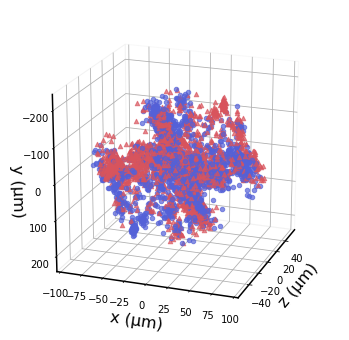

In [75]:
plot_soma_rel(modO_rel_preloc, modO_rel_postloc)

### 3. Tree Sub-blocks

In [10]:
from utils.measure import *

In [18]:
%%time
verbose = False
SBMs_modO_sg_anneal = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=3, B_max=3,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 30s, sys: 624 ms, total: 1min 30s
Wall time: 1min 18s


In [19]:
blocks = [SBM.get_blocks().a for SBM in SBMs_modO_sg_anneal] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.8174425546622855

In [20]:
min([SBM.entropy() for SBM in SBMs_modO_sg_anneal])

9334.51216078003

In [21]:
sbm_modO_sg = SBMs_modO_sg_anneal[np.argmin([SBM.entropy() for SBM in SBMs_modO_sg_anneal])] 

In [22]:
sbm_modO_sg

<BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, directed, with 223 vertices and 2725 edges, 22 internal vertex properties, 2 internal edge properties, at 0x7fd16eaee390>, at 0x7fd16863e1d0>

In [23]:
vw = modO.new_vertex_property("int32_t")
for i, v in enumerate(modO.vertices()):
    vw[v] = sbm_modO_sg.get_blocks().a[i]
modO.vp["modO_sg_3sbm"] = vw

In [24]:
np.unique(modO.vp["modO_sg_3sbm"].a, return_counts=True)

(PropertyArray([0, 1, 2], dtype=int32), array([80, 70, 73]))

In [88]:
g = gt.load_graph("saved/whole-label-ax50-dd100.xml.gz")

In [89]:
g.vp["modO_sg"].a.sum()

PropertyArray(223, dtype=uint64)

In [90]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_3sbm"].a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["modO_sg"][v] == True:
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["modO_sg_3sbm"] = vw

In [99]:
def validate_syn_prob_MI(g, sbm_name, weight='#synapses', norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 14))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)

    # merge scc-0 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 0)]
    center_fv0 = mclass[0]
    # print("center-0", center_fv0)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv0:
            merge_g.merge_vertices(v, center_fv0)

    # merge scc-1 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 1)]
    center_fv1 = mclass[0]
    # print("center-1", center_fv1)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv1:
            merge_g.merge_vertices(v, center_fv1)
            
    # merge scc-2 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 2)]
    center_fv2 = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv2:
            merge_g.merge_vertices(v, center_fv2)

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[[abdm_fv,abdm_fv,abdm_fv,abdi_fv,abdi_fv,abdi_fv],
                        [center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2]].reshape(2,3)
    
    syn_prob_block = A_mg[[center_fv0,center_fv0,center_fv0,center_fv1,center_fv1,center_fv1,center_fv2,center_fv2,center_fv2],
                        [center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2]
                         ].reshape(3,3)

    return syn_prob_abd, syn_prob_block

In [97]:
gen_mask = lambda x: np.array(x, dtype="bool")

In [920]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_{}_3sbm".format(k),  weight='#synapses', norm=True)

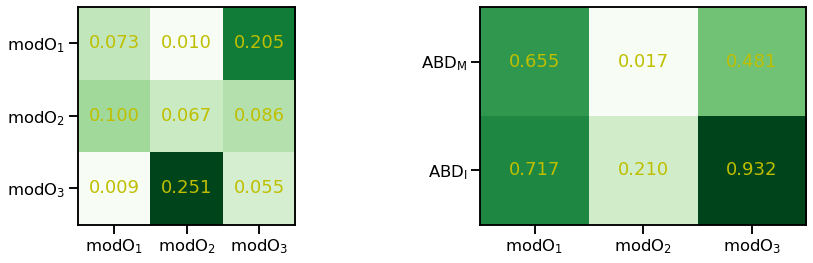

In [106]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [343]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_{}_3sbm".format(k),  weight=None, norm=True)

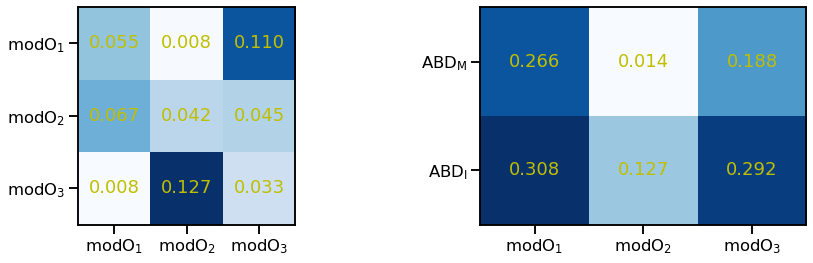

In [345]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [342]:
sbm_modO_sg

<BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, directed, with 223 vertices and 2725 edges, 20 internal vertex properties, 2 internal edge properties, at 0x7fea1b95f898>, at 0x7fe9ae3ac358>

In [709]:
list(modO.vp)

['#connectome_in_degree',
 '#connectome_out_degree',
 'cellid',
 'cellselected',
 'celltype',
 'modO_sg_sbm',
 'sbm_mg',
 'sbm_mg_c',
 'sbm_mg_s',
 'sbm_sc',
 'sbm_sc_c',
 'sbm_sc_s',
 'sbm_sg',
 'sbm_wc',
 'sbm_wc_c',
 'sbm_wc_s',
 'sbm_wg',
 'sbm_wg_c',
 'sbm_wg_s',
 'modO_sg_3sbm']

### Generate 3-cycles from 3-block SBM

In [16]:
ers = gt.adjacency(sbm_modO_sg.get_bg(), sbm_modO_sg.get_ers()).T
out_degs = modO.degree_property_map("out").a
in_degs = modO.degree_property_map("in").a
mrs, theta_out, theta_in = gt.solve_sbm_fugacities(sbm_modO_sg.b.a, ers, out_degs, in_degs)

In [17]:
theta_out

array([0.02592916, 0.05154811, 0.05435579, 0.01362739, 0.00594917,
       0.02123346, 0.00476093, 0.01063055, 0.0008601 , 0.02237602,
       0.01823961, 0.0125612 , 0.00727002, 0.01394336, 0.01120323,
       0.01120323, 0.01535016, 0.00756193, 0.02592916, 0.01120323,
       0.00777632, 0.        , 0.01570828, 0.00080927, 0.00871233,
       0.        , 0.02086935, 0.00862335, 0.02596526, 0.00080927,
       0.01435921, 0.00871233, 0.01261214, 0.0167745 , 0.01063055,
       0.0008601 , 0.00756193, 0.01063055, 0.00777632, 0.00418022,
       0.01362739, 0.0125612 , 0.02824201, 0.00418022, 0.01465934,
       0.02596526, 0.04377344, 0.00986899, 0.00871233, 0.02237602,
       0.01261214, 0.01535016, 0.00986899, 0.01535016, 0.0292027 ,
       0.01394336, 0.02845915, 0.01896006, 0.00777632, 0.0222719 ,
       0.02824201, 0.04377344, 0.02973754, 0.03235921, 0.00971252,
       0.0402019 , 0.        , 0.        , 0.00233859, 0.        ,
       0.        , 0.00727002, 0.00600444, 0.00855806, 0.00353

In [18]:
mrs.todense()

matrix([[393.31673755, 432.39166362,  44.74371376],
        [ 47.84644972, 226.64483038, 903.85638811],
        [799.25764458, 255.16221251, 191.27756768]])

In [28]:
# print(nx.info(pyintergraph.gt2nx(random_modO_sbm3)))

In [96]:
def SBM_sample_three_neuron_motifs(samples, thread, i):
    worker_init_fn(i)
    df = pd.DataFrame()
    for s in range(samples):
        random_modO_sbm3 = gt.generate_maxent_sbm(sbm_modO_sg.b.a, mrs, theta_out, theta_in, directed=True)
        tdf, _ = count_three_neuron_motifs(*graph_to_sets(
                    pyintergraph.gt2nx(random_modO_sbm3)), motifs)
        df = pd.concat((df, pd.DataFrame([tdf])))
    return df

def sample_motifs_parallel_continuous_SBM(fn, samples, threads=8):
    f = partial(fn, samples, threads)
    with ProcessPoolExecutor(max_workers=threads) as executor:
        dfs = executor.map(f, range(threads))
    return pd.concat(dfs, ignore_index=True)

In [20]:
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(pyintergraph.gt2nx(modO)), motifs)

In [ ]:
%%time

s=100 # total 1000 samples (10 workers x 100 continous samples)
sbm3_three_counts = sample_motifs_parallel_continuous_SBM(SBM_sample_three_neuron_motifs, samples=s, threads=10)

In [151]:
# save sampled motif counts from SBM model as intermediate data
# sbm3_three_counts.to_csv("saved/modO_sg_ax50_dd100_3motif_sbm31000.csv", index=False)

In [21]:
# load precomputed sampled motif counts from SBM model
sbm3_three_counts = pd.read_csv("saved/modO_sg_ax50_dd100_3motif_sbm31000.csv")
sbm3_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

In [22]:
# load precomputed sampled motif counts from gCFG model
config_three_counts_R3 = pd.read_csv("saved/modO_sg_ax50_dd100_3motif_R3_1000_cluster.csv")
config_three_counts_R3.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

In [81]:
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(pyintergraph.gt2nx(modO))
er_three_counts_GE = compute_expected_three_neuron_motifs(pyintergraph.gt2nx(modO), three_pr_GE)

In [ ]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, sbm3_three_counts,
                                            cfg_name="SBM", er_name="gER",
                                            subtitle='', ylim=[-0.5, 10], fname="modO_sbm_ax50_dd100_3_violin", figsize=(10,4))

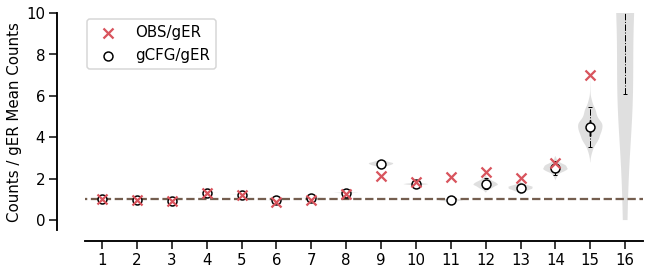

In [95]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_R3,
                                            cfg_name="gCFG", er_name="gER",
                                            subtitle='', ylim=[-0.5, 10], fname="modO_gcfg_ax50_dd100_3_violin", figsize=(10,4))

In [23]:
def cycle_ratio(counts_):
    if type(counts_) == dict:
        counts = pd.DataFrame(data={k:[v] for k,v in counts_.items()})
    else:
        counts = counts_
        
    a_ = [6,7,8,10]
    b_ = [9,12,14]
    c_ = [11,13]
    d_ = [15]
    e_ = [16]
    uni_cyccnt =  counts[[10, 15]].sum(1) + 2 * counts[[12, 14]].sum(1)
    rec_cyccnt = 3 * counts[c_+d_].sum(1) + 6 * counts[e_].sum(1)
    return rec_cyccnt / uni_cyccnt

In [24]:
def uni_cycle_ratio(counts_):
    if type(counts_) == dict:
        counts = pd.DataFrame(data={k:[v] for k,v in counts_.items()})
    else:
        counts = counts_
    uni_cyccnt =  counts[[10]].sum(1)
    rec_cyccnt = 3 * counts[[11]].sum(1)
    return rec_cyccnt / uni_cyccnt

In [25]:
obs_three_counts[11], 

(985,)

In [26]:
sbm3_three_counts[11].mean()

573.94

In [27]:
obs_cycle = cycle_ratio(obs_three_counts).mean()
obs_cycle

1.2268574908647991

In [28]:
obs_uni_cycle = uni_cycle_ratio(obs_three_counts).mean()
obs_uni_cycle

1.1515978176149648

In [29]:
sbm3_cycle = cycle_ratio(sbm3_three_counts)
sbm3_cycle

0      0.743000
1      0.717689
2      0.776460
3      0.697346
4      0.805462
         ...   
995    0.673330
996    0.759398
997    0.711849
998    0.665020
999    0.694306
Length: 1000, dtype: float64

In [30]:
sbm3_uni_cycle = uni_cycle_ratio(sbm3_three_counts)
sbm3_uni_cycle

0      0.677456
1      0.658868
2      0.700279
3      0.582055
4      0.713727
         ...   
995    0.564777
996    0.682173
997    0.624581
998    0.568182
999    0.625235
Length: 1000, dtype: float64

In [31]:
cfg_cycle = cycle_ratio(config_three_counts_R3)
cfg_cycle

0      0.740765
1      0.739901
2      0.683694
3      0.673248
4      0.682903
         ...   
995    0.688776
996    0.689243
997    0.716090
998    0.687356
999    0.669734
Length: 1000, dtype: float64

In [32]:
cfg_uni_cycle = uni_cycle_ratio(config_three_counts_R3)
cfg_uni_cycle

0      0.596787
1      0.571429
2      0.561446
3      0.532278
4      0.551794
         ...   
995    0.525417
996    0.552730
997    0.576685
998    0.551498
999    0.532911
Length: 1000, dtype: float64

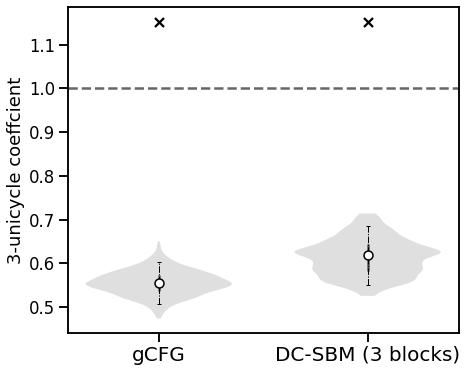

In [33]:
x_labels = ['gCFG', 'DC-SBM (3 blocks)']
data = [cfg_uni_cycle, sbm3_uni_cycle]
fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.scatter([1,2], [obs_uni_cycle, obs_uni_cycle], marker='x', color='k')
parts = ax.violinplot(data, widths=0.7,
                 showmeans=False, showmedians=False, showextrema=False)
for pc in parts['bodies']:
        pc.set_facecolor('#C0C0C0')
        pc.set_alpha(0.5)
ax.set_xticks(np.arange(1, len(x_labels)+1))
ax.set_xticklabels(x_labels, fontsize=20);
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
p5, p95 = np.percentile(data, [5, 95], axis=1)
inds = np.arange(1, len(medians) + 1)
ax.axhline(y=1, color='k', alpha=0.6, linestyle='--', lw=2.5)
ax.scatter(inds, medians, marker='o', color='white', edgecolors='k', 
           s=80, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', alpha=0.6, linestyle='-', lw=2.5)
ax.vlines(inds, p5, p95, color='k', alpha=0.6, linestyle='-.', lw=1.0)
mid, mlen = (p5+p95)/2, (p95-p5)/2
eb = plt.errorbar(inds, (p5+p95)/2, yerr = mlen, ls='none', color='k', capsize=2, elinewidth=1.0) 
eb[-1][0].set_linestyle('-.')
ax.set_xticks(np.arange(1, len(x_labels)+1))
ax.set_xticklabels(x_labels, fontsize=20);
ax.set_ylabel("3-unicycle coeffcient")
plt.savefig("figures/paper/3-unicycle-sbm-overrep.pdf")

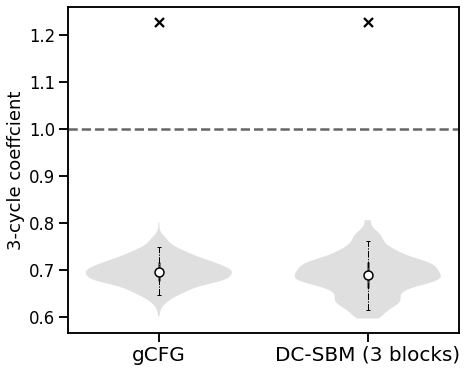

In [34]:
x_labels = ['gCFG', 'DC-SBM (3 blocks)']
data = [cfg_cycle, sbm3_cycle]
fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.scatter([1,2], [obs_cycle, obs_cycle], marker='x', color='k')
parts = ax.violinplot(data, widths=0.7,
                 showmeans=False, showmedians=False, showextrema=False)
for pc in parts['bodies']:
        pc.set_facecolor('#C0C0C0')
        pc.set_alpha(0.5)
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
p5, p95 = np.percentile(data, [5, 95], axis=1)
inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', edgecolors='k', 
           s=80, zorder=3)
ax.axhline(y=1, color='k', alpha=0.6, linestyle='--', lw=2.5)
ax.vlines(inds, quartile1, quartile3, color='k', alpha=0.6, linestyle='-', lw=2.5)
ax.vlines(inds, p5, p95, color='k', alpha=0.6, linestyle='-.', lw=1.0)
mid, mlen = (p5+p95)/2, (p95-p5)/2
eb = plt.errorbar(inds, (p5+p95)/2, yerr = mlen, ls='none', color='k', capsize=2, elinewidth=1.0) 
eb[-1][0].set_linestyle('-.')
ax.set_xticks(np.arange(1, len(x_labels)+1))
ax.set_xticklabels(x_labels, fontsize=20);
ax.set_ylabel("3-cycle coeffcient")
plt.savefig("figures/paper/3-cycle-sbm-overrep.pdf")

In [35]:
obs_three_counts

{1: 1313046,
 2: 429033,
 3: 18339,
 4: 16287,
 5: 15273,
 6: 22064,
 7: 2203,
 8: 2800,
 9: 210,
 10: 2566,
 11: 985,
 12: 146,
 13: 254,
 14: 174,
 15: 78,
 16: 13}

In [516]:
sbm3_three_counts[11].mean()

573.94

In [430]:
obs_three_counts[11] + obs_three_counts[13] + obs_three_counts[15] + 2 * obs_three_counts[16]  

1343

In [428]:
from functools import reduce
import operator

reduce(operator.mul, np.unique(modO.vp["modO_sg_3sbm"].a, return_counts=True)[1])

408800

In [498]:
np.unique(modO.vp["modO_sg_3sbm"].a, return_counts=True)

(PropertyArray([0, 1, 2], dtype=int32), array([80, 70, 73]))

In [511]:
70 * 73 * 0.127, 73 * 80 * 0.110, 80 * 70 * 0.067

(648.97, 642.4, 375.20000000000005)

In [512]:
73 * 0.127 * 0.110 * 80 * 70 * 0.067

382.632712

In [36]:
def unicycle_alignment(gg):
    group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2]]

    gg_3allcycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in gg.edges():
            if (gg.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
               (gg.vp["modO_sg_3sbm"][e1.target()] == grp[1]) and\
               (not e1.source() in gg.get_out_neighbors(e1.target())):

                for e2 in gg.get_out_edges(e1.target()):
                    if (gg.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                       (gg.vp["modO_sg_3sbm"][e2[1]] == grp[2]) and\
                       (not e2[0] in gg.get_out_neighbors(e2[1])):

                        for e3 in gg.get_out_edges(e2[1]):
                            if (gg.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]) and\
                               (not e3[0] in gg.get_out_neighbors(e3[1])):

                                gg_3allcycle_cnt[str(grp)] += 1
        # given unicycles.. 
        # only cycles with all nodes in the same module can be counted multiple times (x3).
        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        gg_3allcycle_cnt[str(grp)] = gg_3allcycle_cnt[str(grp)] / dup_fac

    return(gg_3allcycle_cnt)

In [37]:
def cycle_alignment(gg):
    group_partition = [[0,0,0],[0,0,1],[0,0,2],
                       [0,1,1],[0,1,2],[0,2,2],
                       [1,0,2],[1,1,1],[1,2,1],
                       [1,2,2],[2,2,2]]

    gg_3allbicycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in gg.edges():
            if (gg.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
               (gg.vp["modO_sg_3sbm"][e1.target()] == grp[1]):

                for e2 in gg.get_out_edges(e1.target()):
                    if (gg.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                       (gg.vp["modO_sg_3sbm"][e2[1]] == grp[2]):

                        for e3 in gg.get_out_edges(e2[1]):
                            if (gg.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]):

                                gg_3allbicycle_cnt[str(grp)] += 1

        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        gg_3allbicycle_cnt[str(grp)] = gg_3allbicycle_cnt[str(grp)] / dup_fac

    return gg_3allbicycle_cnt

In [74]:
unicycle_alignment(modO)

{'[0, 0, 0]': 18.0,
 '[0, 0, 1]': 10.0,
 '[0, 0, 2]': 6.0,
 '[0, 1, 1]': 2.0,
 '[0, 1, 2]': 859.0,
 '[0, 2, 2]': 5.0,
 '[1, 0, 2]': 1.0,
 '[1, 1, 1]': 3.0,
 '[1, 2, 1]': 32.0,
 '[1, 2, 2]': 40.0,
 '[2, 2, 2]': 9.0}

In [112]:
cycle_alignment(modO)

{'[0, 0, 0]': 30.0,
 '[0, 0, 1]': 16.0,
 '[0, 0, 2]': 8.0,
 '[0, 1, 1]': 4.0,
 '[0, 1, 2]': 971.0,
 '[0, 2, 2]': 8.0,
 '[1, 0, 2]': 7.0,
 '[1, 1, 1]': 7.0,
 '[1, 2, 1]': 119.0,
 '[1, 2, 2]': 161.0,
 '[2, 2, 2]': 12.0}

In [78]:
%%time
random_modO_sbm3 = gt.generate_maxent_sbm(sbm_modO_sg.b.a, mrs, theta_out, theta_in, directed=True)
vw = random_modO_sbm3.new_vertex_property("int32_t")
vw.a = sbm_modO_sg.b.a
random_modO_sbm3.vp["modO_sg_3sbm"] = vw

uni_dict_random = unicycle_alignment(random_modO_sbm3)
pd.DataFrame([uni_dict_random])

,"[0, 0, 0]","[0, 0, 1]","[0, 0, 2]","[0, 1, 1]","[0, 1, 2]","[0, 2, 2]","[1, 0, 2]","[1, 1, 1]","[1, 2, 1]","[1, 2, 2]","[2, 2, 2]"
0,29.0,14.0,14.0,9.0,334.0,10.0,1.0,5.0,58.0,53.0,3.0


In [38]:
def SBM_sample_three_unicycles(samples, thread, i):
    worker_init_fn(i)
    df = pd.DataFrame()
    for s in range(samples):
        random_modO_sbm3 = gt.generate_maxent_sbm(sbm_modO_sg.b.a, mrs, theta_out, theta_in, directed=True)
        vw = random_modO_sbm3.new_vertex_property("int32_t")
        vw.a = sbm_modO_sg.b.a
        random_modO_sbm3.vp["modO_sg_3sbm"] = vw
        tdf = unicycle_alignment(random_modO_sbm3)
        df = pd.concat((df, pd.DataFrame([tdf])))
    return df

def SBM_sample_three_cycles(samples, thread, i):
    worker_init_fn(i)
    df = pd.DataFrame()
    for s in range(samples):
        random_modO_sbm3 = gt.generate_maxent_sbm(sbm_modO_sg.b.a, mrs, theta_out, theta_in, directed=True)
        vw = random_modO_sbm3.new_vertex_property("int32_t")
        vw.a = sbm_modO_sg.b.a
        random_modO_sbm3.vp["modO_sg_3sbm"] = vw
        tdf = cycle_alignment(random_modO_sbm3)
        df = pd.concat((df, pd.DataFrame([tdf])))
    return df

def sample_motifs_parallel_continuous_SBM(fn, samples, threads=8):
    f = partial(fn, samples, threads)
    with ProcessPoolExecutor(max_workers=threads) as executor:
        dfs = executor.map(f, range(threads))
    return pd.concat(dfs, ignore_index=True)

In [34]:
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(pyintergraph.gt2nx(modO)), motifs)

In [39]:
%%time

s=100 # total 1000 samples (10 workers x 100 continous samples)
sbm3_3uni_counts = sample_motifs_parallel_continuous_SBM(SBM_sample_three_unicycles, samples=s, threads=10)

CPU times: user 24 ms, sys: 100 ms, total: 124 ms
Wall time: 2min 58s


In [40]:
%%time

s=100 # total 1000 samples (10 workers x 100 continous samples)
sbm3_3all_counts = sample_motifs_parallel_continuous_SBM(SBM_sample_three_cycles, samples=s, threads=10)

CPU times: user 20 ms, sys: 104 ms, total: 124 ms
Wall time: 2min 11s


In [76]:
unicycle_alignment(modO)['[0, 1, 2]'] / sbm3_3uni_counts['[0, 1, 2]'].mean()

2.1956393937070264

In [78]:
cycle_alignment(modO)['[0, 1, 2]'] / sbm3_3all_counts['[0, 1, 2]'].mean()

2.1545698626489447

In [41]:
sbm3_3uni_counts['[0, 1, 2]'].mean(), sbm3_3uni_counts['[0, 1, 2]'].std()

(391.23, 40.50231521206581)

In [42]:
sbm3_3all_counts['[0, 1, 2]'].mean(), sbm3_3all_counts['[0, 1, 2]'].std()

(450.67, 46.985835831330796)

In [44]:
group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2]]

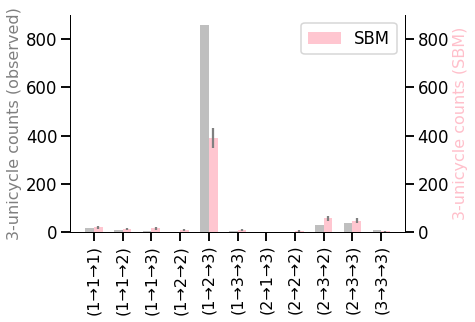

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax2 = ax.twinx()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_linewidth(1)
ax2.spines['left'].set_linewidth(1)
ax2.spines['bottom'].set_linewidth(1)

ax.bar(np.arange(11)-0.15, list(unicycle_alignment(modO).values()), width=0.3, alpha=0.5, color='gray', 
       label='Observed')
ax2.bar(np.arange(11)+0.15, [sbm3_3uni_counts[k].mean() for k in sbm3_3uni_counts.keys()], 
        yerr=[sbm3_3uni_counts[k].std() for k in sbm3_3uni_counts.keys()], ecolor='gray',
        width=0.3, alpha=0.9, color='pink', label='SBM')

ax.set_ylabel('3-unicycle counts (observed)', alpha=1, color='gray', fontsize=16)
ax2.set_ylabel('3-unicycle counts (SBM)', alpha=1, color='pink', fontsize=16)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=16, rotation = 90)

ax.set_ylim([0,900])
ax2.set_ylim([0,900])
ax2.legend()
plt.savefig('figures/paper/3-unicycle-align-sbm.pdf', bbox_inches="tight")

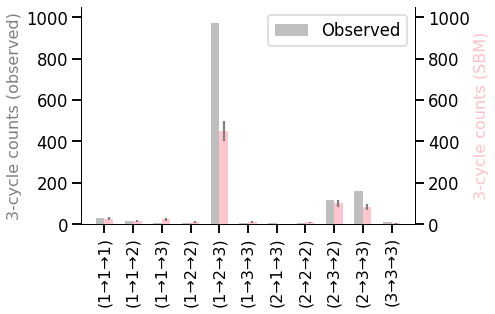

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax2 = ax.twinx()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
# ax2.spines["right"].set_linewidth(1)
ax2.spines['left'].set_linewidth(1)
ax2.spines['bottom'].set_linewidth(1)

ax.bar(np.arange(11)-0.15, list(cycle_alignment(modO).values()), width=0.3, alpha=0.5, color='gray', 
       label='Observed')
ax2.bar(np.arange(11)+0.15, [sbm3_3all_counts[k].mean() for k in sbm3_3uni_counts.keys()], 
        yerr=[sbm3_3all_counts[k].std() for k in sbm3_3all_counts.keys()], ecolor='gray',
        width=0.3, alpha=0.9, color='pink', label='SBM')

ax.set_ylabel('3-cycle counts (observed)', alpha=1, color='gray', fontsize=16)
ax2.set_ylabel('3-cycle counts (SBM)', alpha=1, color='pink', fontsize=16)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=16, rotation = 90)


ax.set_ylim([0,1050])
ax2.set_ylim([0,1050])
ax.legend()
plt.savefig('figures/paper/3-cycle-align-sbm.pdf', bbox_inches="tight")

In [688]:
%%time 

# count number of 3-cycle in (1,2,3)
group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2]]

modO3allbicycle_cnt = {str(grp): 0 for grp in group_partition}

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
           (modO.vp["modO_sg_3sbm"][e1.target()] == grp[1]):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                   (modO.vp["modO_sg_3sbm"][e2[1]] == grp[2]):

                    for e3 in modO.get_out_edges(e2[1]):
                        if (modO.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                           (e1.source() == e3[1]):

                            modO3allbicycle_cnt[str(grp)] += 1
    # given unicycles.. 
    # only cycles with all nodes in the same module can be counted multiple times (x3).
    dup_fac = 1 if len(np.unique(grp)) > 1 else 3
    modO3allbicycle_cnt[str(grp)] = modO3allbicycle_cnt[str(grp)] / dup_fac

print(modO3allbicycle_cnt)

{'[0, 0, 0]': 30.0, '[0, 0, 1]': 16.0, '[0, 0, 2]': 8.0, '[0, 1, 1]': 4.0, '[0, 1, 2]': 971.0, '[0, 2, 2]': 8.0, '[1, 0, 2]': 7.0, '[1, 1, 1]': 7.0, '[1, 2, 1]': 119.0, '[1, 2, 2]': 161.0, '[2, 2, 2]': 12.0}
CPU times: user 1 s, sys: 8 ms, total: 1.01 s
Wall time: 1.01 s


In [689]:
sum(list(modO3allbicycle_cnt.values()))

1343.0

In [690]:
obs_three_counts[11] + obs_three_counts[13] + obs_three_counts[15] + 2 * obs_three_counts[16]

1343

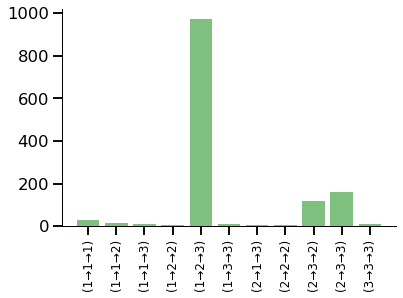

In [692]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.bar(range(11), height=list(modO3allbicycle_cnt.values()), color='green', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

### Excluding DO Neurons

In [646]:
sum([loc[0] < 300 for loc in modO_soma_loc_3b[0]])

43

In [647]:
sum([loc[0] >= 300 for loc in modO_soma_loc_3b[0]])

36

In [665]:
do_filter = modO.new_vertex_property("bool")
for v in modO.vertices():
    do_filter[v] = True
    cid = modO.vp["cellid"][v]
    if cid in cell_loc.keys() and modO.vp["modO_sg_3sbm"][v] == 0:
        if cell_loc[cid][0] < 300:
            do_filter[v] = False

In [666]:
modO.set_vertex_filter(do_filter)

In [675]:
modO.clear_filters()

In [667]:
modO

<Graph object, directed, with 180 vertices and 1782 edges, 20 internal vertex properties, 2 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fea1b95f898, at 0x7fe983b5ef60>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fea1b95f898, at 0x7fe983c3b898>, False), at 0x7fea1b95f898>

In [668]:
np.unique(modO.vp["modO_sg_3sbm"].a, return_counts=True)

(PropertyArray([0, 1, 2], dtype=int32), array([80, 70, 73]))

In [669]:
np.unique([modO.vp["modO_sg_3sbm"][v] for v in modO.vertices()], return_counts=True)

(array([0, 1, 2]), array([37, 70, 73]))

In [670]:
%%time 

# count number of 3-cycle in (1,2,3)
group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2]]

modO3allcycle_cnt = {str(grp): 0 for grp in group_partition}

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
           (modO.vp["modO_sg_3sbm"][e1.target()] == grp[1]) and\
           (not e1.source() in modO.get_out_neighbors(e1.target())):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                   (modO.vp["modO_sg_3sbm"][e2[1]] == grp[2]) and\
                   (not e2[0] in modO.get_out_neighbors(e2[1])):

                    for e3 in modO.get_out_edges(e2[1]):
                        if (modO.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                           (e1.source() == e3[1]) and\
                           (not e3[0] in modO.get_out_neighbors(e3[1])):

                            modO3allcycle_cnt[str(grp)] += 1
    # given unicycles.. 
    # only cycles with all nodes in the same module can be counted multiple times (x3).
    dup_fac = 1 if len(np.unique(grp)) > 1 else 3
    modO3allcycle_cnt[str(grp)] = modO3allcycle_cnt[str(grp)] / dup_fac

print(modO3allcycle_cnt)

{'[0, 0, 0]': 0.0, '[0, 0, 1]': 3.0, '[0, 0, 2]': 0.0, '[0, 1, 1]': 0.0, '[0, 1, 2]': 310.0, '[0, 2, 2]': 5.0, '[1, 0, 2]': 1.0, '[1, 1, 1]': 3.0, '[1, 2, 1]': 32.0, '[1, 2, 2]': 40.0, '[2, 2, 2]': 9.0}
CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.33 s


In [671]:
modO3allcycle_cnt

{'[0, 0, 0]': 0.0,
 '[0, 0, 1]': 3.0,
 '[0, 0, 2]': 0.0,
 '[0, 1, 1]': 0.0,
 '[0, 1, 2]': 310.0,
 '[0, 2, 2]': 5.0,
 '[1, 0, 2]': 1.0,
 '[1, 1, 1]': 3.0,
 '[1, 2, 1]': 32.0,
 '[1, 2, 2]': 40.0,
 '[2, 2, 2]': 9.0}

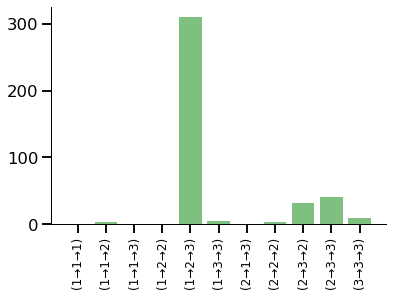

In [672]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.bar(range(11), height=list(modO3allcycle_cnt.values()), color='green', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

### Count 2 cycles

In [711]:
%%time 

# count number of 2-cycle in (1,2)
group_partition = [[0,0],[0, 1],[1,1]]

modObiedge_cnt = {str(grp): 0 for grp in group_partition}

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["modO_sg_sbm"][e1.source()] == grp[0]) and\
           (modO.vp["modO_sg_sbm"][e1.target()] == grp[1]):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["modO_sg_sbm"][e2[0]] == grp[1]) and\
                   (e1.source() == e2[1]):

                    modObiedge_cnt[str(grp)] += 1

    dup_fac = 1 if len(np.unique(grp)) > 1 else 2
    modObiedge_cnt[str(grp)] = modObiedge_cnt[str(grp)] / dup_fac

print(modObiedge_cnt)

{'[0, 0]': 60.0, '[0, 1]': 18.0, '[1, 1]': 33.0}
CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 223 ms


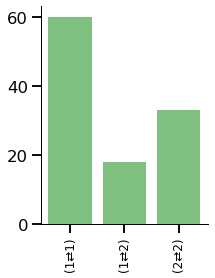

In [716]:
fig, ax = plt.subplots(1, 1, figsize=(3,4))
plt.bar(range(3), height=list(modObiedge_cnt.values()), color='green', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["({}⇄{})".format(grp[0]+1, grp[1]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

In [717]:
%%time 

# count number of 2-cycle in (1,2)
group_partition = [[0,0],[0,1],[0,2],[1,1],[1,2],[2,2]]

modObiedge_cnt = {str(grp): 0 for grp in group_partition}

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
           (modO.vp["modO_sg_3sbm"][e1.target()] == grp[1]):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                   (e1.source() == e2[1]):

                    modObiedge_cnt[str(grp)] += 1

    dup_fac = 1 if len(np.unique(grp)) > 1 else 2
    modObiedge_cnt[str(grp)] = modObiedge_cnt[str(grp)] / dup_fac

print(modObiedge_cnt)

{'[0, 0]': 24.0, '[0, 1]': 4.0, '[0, 2]': 3.0, '[1, 1]': 8.0, '[1, 2]': 68.0, '[2, 2]': 4.0}
CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 207 ms


In [721]:
np.sum(list(modObiedge_cnt.values()))

111.0

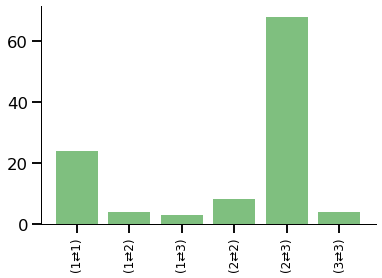

In [718]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.bar(range(6), height=list(modObiedge_cnt.values()), color='green', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(["({}⇄{})".format(grp[0]+1, grp[1]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

### More blocks..

In [13]:
from utils.measure import *

In [287]:
%%time
verbose = False
SBMs_sg_anneal_2b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=2, B_max=2,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 35s, sys: 104 ms, total: 1min 35s
Wall time: 1min 23s


In [288]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_2b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.9968111609367215

In [391]:
%%time
verbose = False
SBMs_sg_anneal_2b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=2, B_max=2,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(50)]

CPU times: user 7min 47s, sys: 920 ms, total: 7min 48s
Wall time: 6min 54s


In [392]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_2b] 
rscore = []
for i in range(50):
    for j in range(i+1, 50):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.9005254362076912

In [270]:
%%time
verbose = False
SBMs_sg_anneal_3b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=3, B_max=3,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 31s, sys: 140 ms, total: 1min 32s
Wall time: 1min 20s


In [271]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_3b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.8930122948060168

In [272]:
%%time
verbose = False
SBMs_sg_anneal_4b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=4, B_max=4,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 28s, sys: 44 ms, total: 1min 29s
Wall time: 1min 18s


In [273]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_4b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.9402649286057359

In [274]:
%%time
verbose = False
SBMs_sg_anneal_5b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=5, B_max=5,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 13s


In [275]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_5b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.8813342490472534

In [276]:
%%time
verbose = False
SBMs_sg_anneal_6b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=6, B_max=6,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 13s


In [277]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_6b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.9034774684998899

In [394]:
sbm_sg_2b = SBMs_sg_anneal_2b[np.argmin([SBM.entropy() for SBM in SBMs_sg_anneal_2b])] 
sbm_sg_3b = SBMs_sg_anneal_3b[np.argmin([SBM.entropy() for SBM in SBMs_sg_anneal_3b])] 
sbm_sg_4b = SBMs_sg_anneal_4b[np.argmin([SBM.entropy() for SBM in SBMs_sg_anneal_4b])] 
sbm_sg_5b = SBMs_sg_anneal_5b[np.argmin([SBM.entropy() for SBM in SBMs_sg_anneal_5b])] 
sbm_sg_6b = SBMs_sg_anneal_6b[np.argmin([SBM.entropy() for SBM in SBMs_sg_anneal_6b])] 

In [924]:
sbm_sg_3b.entropy()

9334.51216078003

In [925]:
sbm_sg_4b.entropy()

9132.003448655028

In [285]:
import plotly.graph_objects as go
from IPython.core.display import display
from IPython.display import IFrame

In [280]:
# calculate source, target, values
def get_stv(source_labels, target_labels):
    s, t, v = [], [], []
    links, values = np.unique(list(zip(source_labels, target_labels)), 
                      axis=0, return_counts=True)
    for i in range(len(links)):
        s.append(links[i][0])
        t.append(links[i][1])
        v.append(values[i])
        
    return s, t, v

In [706]:
sbms = [0, sbm_sg_2b, sbm_sg_3b, sbm_sg_4b, sbm_sg_5b, sbm_sg_6b]
total_num_block = 0
source, target, value = [], [], []
label = ["modO", " ", " "]
for i in range(5):
    if i > 0:
        stmp, ttmp, vtmp = get_stv(sbms[i].get_blocks().a + total_num_block, 
                               sbms[i+1].get_blocks().a + total_num_block + i + 1)
    else:
        stmp, ttmp, vtmp = get_stv(np.zeros(len(list(modO.vertices()))) + total_num_block, 
                               sbms[i+1].get_blocks().a + total_num_block + i + 1)
    total_num_block = total_num_block + i + 1
    source = source + stmp
    target = target + ttmp
    value = value + vtmp
    if i > 0: 
        label = label + ["{}-{}".format(i+2, j+1) for j in range(i+2)]

In [707]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

In [708]:
fig = go.Figure(data)
fig.write_html('figures/sankey-sbm-modO.html')
display(IFrame('figures/sankey-sbm-modO.html', width=900, height=600))

In [339]:
sbms = [0, sbm_sg_2b, sbm_sg_3b, sbm_sg_6b]
total_num_block = 0
source, target, value = [], [], []
label = ["modO", "modO_I", "modO_M"]
for i in range(3):
    if i > 0:
        stmp, ttmp, vtmp = get_stv(sbms[i].get_blocks().a + total_num_block, 
                               sbms[i+1].get_blocks().a + total_num_block + i + 1)
    else:
        stmp, ttmp, vtmp = get_stv(np.zeros(len(list(modO.vertices()))) + total_num_block, 
                               sbms[i+1].get_blocks().a + total_num_block + i + 1)
    total_num_block = total_num_block + i + 1
    source = source + stmp
    target = target + ttmp
    value = value + vtmp
    if i > 0 and i < 2: 
        label = label + ["{}-{}".format(i+2, j+1) for j in range(i+2)]
    elif i >= 2:
        label = label + ["{}-{}".format(i+4, j+1) for j in range(i+4)]

In [340]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

In [341]:
fig = go.Figure(data)
fig.write_html('figures/sankey-sbm-modO.html')
display(IFrame('figures/sankey-sbm-modO.html', width=900, height=600))

In [ ]:
%%time

s=100 # total 1000 samples (10 workers x 100 continous samples)
# sbm6_three_counts = sample_motifs_parallel_continuous_SBM(SBM_sample_three_neuron_motifs, samples=s, threads=10)

In [151]:
# save sampled motif counts from SBM model as intermediate data
sbm6_three_counts.to_csv("saved/modO_sg_ax50_dd100_3motif_sbm61000.csv", index=False)

In [152]:
# load precomputed sampled motif counts from SBM model
sbm6_three_counts = pd.read_csv("saved/modO_sg_ax50_dd100_3motif_sbm61000.csv")
sbm6_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

In [367]:
modO.vp["cellid"].a[sbm_sg_2b.get_blocks().a == 0]

PropertyArray([76181, 76210, 76469, 76622, 76623, 76626, 76629, 76667,
               76682, 76688, 76701, 76834, 76885, 77121, 77126, 77127,
               77142, 77152, 77232, 77327, 77357, 77369, 77389, 77446,
               77447, 77465, 77467, 77592, 77621, 77636, 77645, 77651,
               77656, 77684, 77689, 77740, 77797, 77805, 77816, 77821,
               77822, 77826, 77844, 77845, 77848, 77868, 77872, 77927,
               77933, 78150, 78226, 78241, 78246, 78254, 78255, 78256,
               78297, 78299, 78321, 78338, 78351, 78356, 78404, 78406,
               78421, 78441, 78543, 78545, 78572, 78633, 78667, 78679,
               78914, 79022, 79033, 79048, 79055, 79059, 79062, 79067,
               79074, 79078, 79720, 79722, 79743, 79746, 79852, 79921,
               79953, 79962, 80163, 80167, 80177, 80179, 80185, 80204,
               80206, 80210, 80271, 80314, 80472, 80510, 80539, 80542,
               80548, 80629, 80679, 80750, 80757, 80956, 81295, 81297,
      

In [522]:
76197, 77821, 77460

(76197, 77821, 77460)

In [527]:
modO.vp["cellid"].a[sbm_sg_3b.get_blocks().a == 1]

PropertyArray([76210, 76626, 76692, 76834, 77126, 77127, 77142, 77232,
               77237, 77327, 77446, 77447, 77465, 77467, 77591, 77602,
               77607, 77821, 77822, 77826, 77844, 77845, 77848, 77933,
               78150, 78338, 78351, 78356, 78404, 78406, 78421, 78441,
               78543, 78545, 78572, 78667, 78841, 78883, 79022, 79033,
               79048, 79054, 79055, 79062, 79067, 79074, 79078, 79720,
               79722, 79743, 79746, 79852, 79953, 79962, 80262, 80314,
               80956, 81295, 81297, 81312, 81338, 81363, 81374, 81417,
               81550, 81559, 81580, 81773, 81792, 81870], dtype=int32)

In [866]:
def plot_soma_blocks(locs, colors):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    for loc, col in zip(locs, colors):
        for ll in loc:
            (x, y, z) = ll
            ax.scatter(z, x, y, c=col, marker='o', alpha=0.7)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.set_xlabel('   z (μm)', fontsize=16)
    ax.set_ylabel('x (μm)', fontsize=16)
    ax.set_zlabel('y (μm)', fontsize=16)

    ax.view_init(-160, -20)

    plt.show()

In [881]:
cell_loc_modO = np.array([cell_loc[v] for v in modO.vp["cellid"].a if v in cell_loc.keys()])

In [882]:
cell_loc_modO[:,0].max() - cell_loc_modO[:,0].min()

93.03999999999999

In [883]:
cell_loc_modO[:,1].max() - cell_loc_modO[:,1].min()

223.60000000000002

In [884]:
cell_loc_modO[:,2].max() - cell_loc_modO[:,2].min()

54.269999999999996

In [508]:
modO_soma_loc_3b = [[cell_loc[v] 
                       for v in modO.vp["cellid"].a[sbm_sg_3b.get_blocks().a == i] 
                       if v in cell_loc.keys()] 
                    for i in range(3)]

In [509]:
colors = ["red", "green", "blue"]

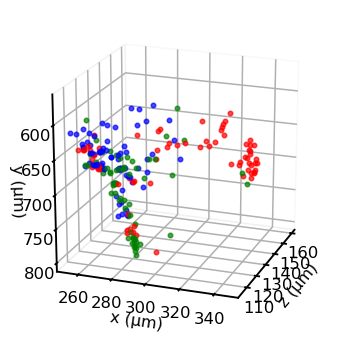

In [867]:
plot_soma_blocks(modO_soma_loc_3b, colors)

In [399]:
def validate_syn_prob_MI_multi(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 14))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat([abdm_fv,abdi_fv], len(bids)),
                        np.tile(center_fvs, 2)].reshape(2, len(bids))
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [564]:
80 / (80 + 70  + 73)

0.35874439461883406

In [401]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, sbm_sg_2b.get_blocks().a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["sbm_sg_2b"] = vw

In [402]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "sbm_{}_2b".format(k),  weight='#synapses', bids=[0,1], norm=True)

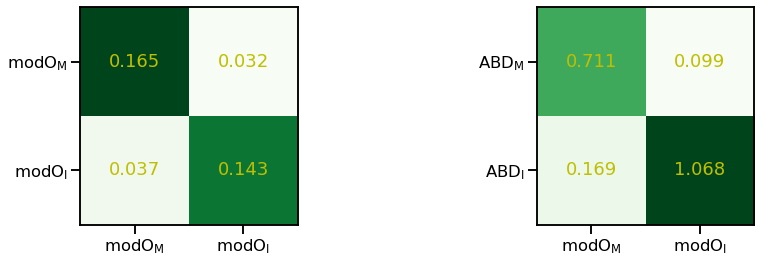

In [404]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$modO_M$", "$modO_I$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$modO_M$", "$modO_I$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$modO_M$", "$modO_I$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [565]:
70 / (80 + 70  + 73)

0.31390134529147984

In [566]:
73 / (80 + 70  + 73)

0.3273542600896861

### Cell types

In [693]:
typenames = ['Saccadic_M', 'Saccadic_I', 'IBN', 'IBNmirrorPop', 'RS', 'Vestibular_DO', 'Vestibular_MO', 'Vestibular_TO', 'Integrator_r456I', 'Integrator_r456M', 'Integrator_r456MI', 'Integrator_r56M', 'Integrator_r78ipis', 'Integrator_r78contra', 'Abducens_M', 'Abducens_I']

In [694]:
type_filter = np.array(modO.vp["celltype"].a != -1)

In [695]:
sbm_sg_3b

<BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, directed, with 223 vertices and 2725 edges, 20 internal vertex properties, 2 internal edge properties, at 0x7fea1b95f898>, at 0x7fe9890137f0>

In [933]:
show_index = [4,5,8,9,10,11,12]

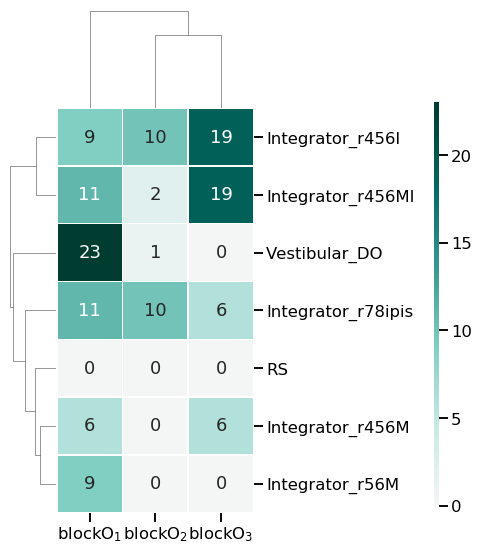

In [935]:
dic_SBM2Type = np.array([np.array(sbm_sg_3b.get_blocks().a)[type_filter].tolist(), 
                         np.array(modO.vp["celltype"].a)[type_filter].tolist()]).T
typeM = np.zeros((3, 16))
for i in range(3):
#     print("---")
#     print("SBM type: {}".format(i))
    ids, cnts = np.unique(dic_SBM2Type[dic_SBM2Type[:,0]==i][:,1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        typeM[i, nid] = cnt
#         print(str(cnt)+" x "+str(name))

type_grid = sns.clustermap(typeM.T[show_index], 
               center=0, 
            xticklabels=["$blockO_1$", "$blockO_2$", "$blockO_3$"],
            yticklabels=np.array(typenames)[show_index],
            figsize=(6.2,8),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
plt.show()

In [952]:
ni_ipis_cid = modO.vp["cellid"].a[np.array(modO.vp["celltype"].a)==12]

In [951]:
abd_m_cid = g.vp["cellid"].a[(np.array(g.vp["celltype"].a) == 14)]

In [950]:
abd_i_cid = g.vp["cellid"].a[(np.array(g.vp["celltype"].a) == 15)]

In [979]:
ni_ipis_nodes = [v for v in g.vertices() if g.vp["cellid"][v] in ni_ipis_cid]
abd_m_nodes = [v for v in g.vertices() if g.vp["cellid"][v] in abd_m_cid]
abd_m_nodes = [int(v) for v in abd_m_nodes]
abd_i_nodes = [v for v in g.vertices() if g.vp["cellid"][v] in abd_i_cid]
abd_i_nodes = [int(v) for v in abd_i_nodes]

In [985]:
def get_syn_to_abd(node):
    syn_to_m = sum([e[2] for e in g.get_out_edges(node, eprops=[g.ep["#synapses"]]) if e[1] in abd_m_nodes])
    syn_to_i = sum([e[2] for e in g.get_out_edges(node, eprops=[g.ep["#synapses"]]) if e[1] in abd_i_nodes])
    return syn_to_m, syn_to_i

In [989]:
ipsi_to_abd_dict = {cid: get_syn_to_abd(node) for cid, node in zip(ni_ipis_cid, ni_ipis_nodes)}

In [995]:
ipsi_to_block_dict = {modO.vp["cellid"][v]: modO.vp["modO_sg_3sbm"][v] for v in modO.vertices() if modO.vp["celltype"][v]==12}

In [990]:
ipsi_to_abd_dict

{76181: (39, 44),
 76197: (0, 63),
 76623: (11, 31),
 76701: (0, 28),
 77327: (2, 10),
 77369: (4, 16),
 77592: (20, 50),
 77822: (0, 4),
 77844: (0, 3),
 77845: (0, 2),
 77868: (23, 49),
 77872: (24, 66),
 78404: (2, 6),
 78406: (0, 8),
 78421: (0, 14),
 78633: (0, 1),
 78667: (0, 2),
 79033: (0, 1),
 79042: (5, 0),
 79060: (29, 0),
 79746: (0, 1),
 80271: (1, 4),
 80596: (9, 0),
 80606: (8, 3),
 80750: (8, 0),
 80885: (21, 0),
 81683: (2, 6)}

In [1026]:
def show_MI_distribution(nodes):
    fig, ax = plt.subplots(1,1,figsize=(4,6*len(nodes)/11))
    ax.barh([str(n) for n in nodes], [ipsi_to_abd_dict[n][0] for n in nodes], color='g', alpha=0.6, label='M')
    ax.barh([str(n) for n in nodes], [ipsi_to_abd_dict[n][1] for n in nodes], color='red', alpha=0.6,
           left=[ipsi_to_abd_dict[n][0] for n in nodes],
           label='I')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("# of synapses")
    plt.legend()
    plt.show()

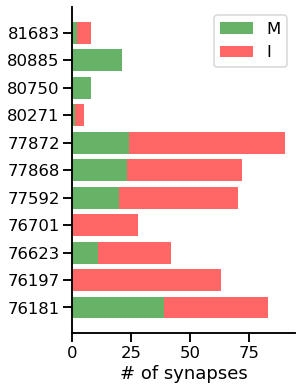

In [1027]:
show_MI_distribution([v for v in ipsi_to_block_dict.keys() if ipsi_to_block_dict[v] == 0])

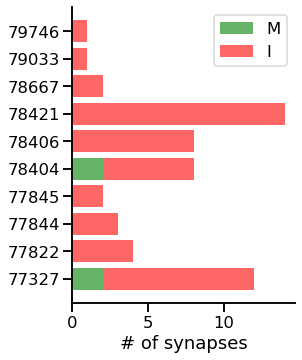

In [1028]:
show_MI_distribution([v for v in ipsi_to_block_dict.keys() if ipsi_to_block_dict[v] == 1])

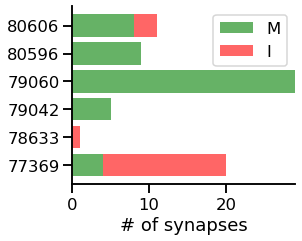

In [1029]:
show_MI_distribution([v for v in ipsi_to_block_dict.keys() if ipsi_to_block_dict[v] == 2])

In [732]:
def validate_syn_prob_input_multi(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

#     # merge sink neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 1)]
#     fv = mclass[0]
#     # print("source", fv)
#     for i, v in enumerate(m.vertices()):
#         if v in mclass and v != fv:
#             merge_g.merge_vertices(v, fv)

    # merge souce saccadic M neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 0))]
    sacm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != sacm_fv:
            merge_g.merge_vertices(v, sacm_fv)
        
    # merge souce saccadic I neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 1))]
    saci_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != saci_fv:
            merge_g.merge_vertices(v, saci_fv)
            
    # merge souce IBN neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 3))]
    ibn_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != ibn_fv:
            merge_g.merge_vertices(v, ibn_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat(center_fvs, 3),
                        np.tile([sacm_fv, saci_fv, ibn_fv], len(bids))].reshape(len(bids), 3)
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [740]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_sbm".format(k),  weight='#synapses', bids=[0,1], norm=True)

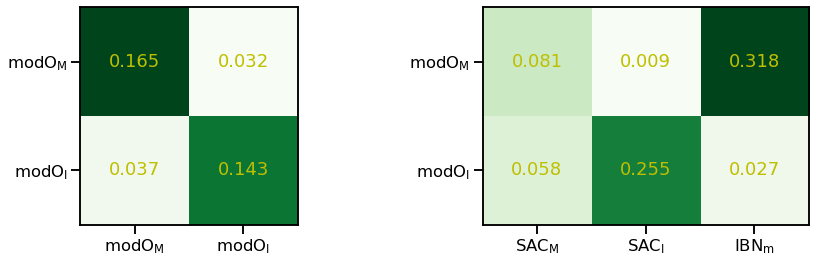

In [741]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$modO_M$", "$modO_I$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$modO_M$", "$modO_I$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$modO_M$", "$modO_I$"])

plt.show()

In [886]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_3sbm".format(k),  weight='#synapses', bids=[0,1,2], norm=True)

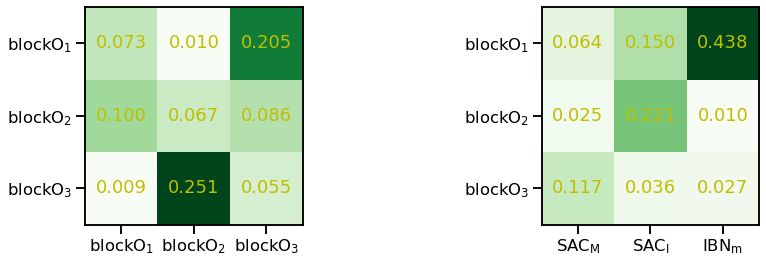

In [888]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [894]:
sum(g.vp['celltype'].a == 0), sum(g.vp['celltype'].a == 1), sum(g.vp['celltype'].a == 3)

(13, 8, 14)

In [895]:
sum(g.vp['celltype'].a == 14), sum(g.vp['celltype'].a == 15)

(29, 21)

### Significance

In [815]:
u = modO.copy()

In [847]:
gt.random_rewire(u, 'configuration')

295

In [848]:
%%time
verbose = False
erSBMs_sg_anneal_2b = [gt.minimize_blockmodel_dl(u, deg_corr=True, 
                                B_min=2, B_max=2,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 55s, sys: 260 ms, total: 1min 56s
Wall time: 1min 43s


In [849]:
blocks = [SBM.get_blocks().a for SBM in erSBMs_sg_anneal_2b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.5662855680792901

In [850]:
ersbm_2b = erSBMs_sg_anneal_2b[np.argmin([SBM.entropy() for SBM in erSBMs_sg_anneal_2b])]

In [851]:
ersbm_2b.get_ers().a, ersbm_2b.get_nr().a

(PropertyArray([1265,  679,  706,   75], dtype=int32),
 PropertyArray([160,  63], dtype=int32))

In [852]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, ersbm_2b.get_blocks().a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["ersbm_sg_2b"] = vw

In [853]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "ersbm_{}_2b".format(k),  weight='#synapses', bids=[0,1], norm=True)

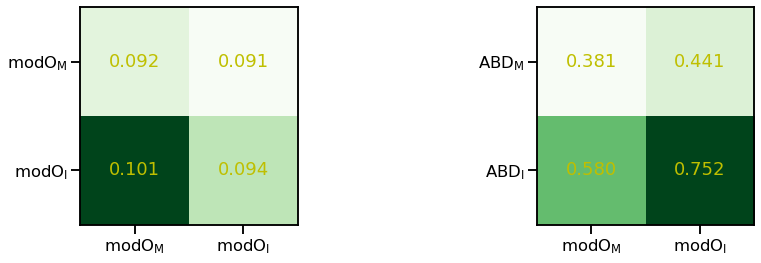

In [854]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$modO_M$", "$modO_I$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$modO_M$", "$modO_I$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$modO_M$", "$modO_I$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [855]:
%%time
verbose = False
erSBMs_sg_anneal_3b = [gt.minimize_blockmodel_dl(u, deg_corr=True, 
                                B_min=3, B_max=3,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 50s, sys: 164 ms, total: 1min 51s
Wall time: 1min 40s


In [856]:
blocks = [SBM.get_blocks().a for SBM in erSBMs_sg_anneal_3b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.5264107156483839

In [857]:
ersbm_3b = erSBMs_sg_anneal_3b[np.argmin([SBM.entropy() for SBM in erSBMs_sg_anneal_3b])]

In [858]:
ersbm_3b.get_ers().a, ersbm_3b.get_nr().a

(PropertyArray([170, 316, 205, 289, 482, 753, 100, 410], dtype=int32),
 PropertyArray([ 55, 123,  45], dtype=int32))

In [859]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, ersbm_3b.get_blocks().a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["ersbm_sg_3b"] = vw

In [860]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "ersbm_{}_3b".format(k),  weight='#synapses', bids=[0,1,2], norm=True)

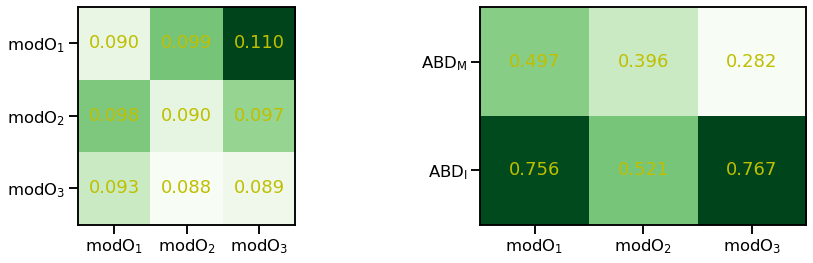

In [861]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$modO_1$", "$modO_2$", "$modO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [898]:
def validate_syn_prob_input_2abd(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

#     # merge sink neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 1)]
#     fv = mclass[0]
#     # print("source", fv)
#     for i, v in enumerate(m.vertices()):
#         if v in mclass and v != fv:
#             merge_g.merge_vertices(v, fv)

    # merge souce saccadic M neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 0))]
    sacm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != sacm_fv:
            merge_g.merge_vertices(v, sacm_fv)
        
    # merge souce saccadic I neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 1))]
    saci_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != saci_fv:
            merge_g.merge_vertices(v, saci_fv)
            
    # merge souce IBN neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 3))]
    ibn_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != ibn_fv:
            merge_g.merge_vertices(v, ibn_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp['celltype'].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat(center_fvs, 3),
                        np.tile([sacm_fv, saci_fv, ibn_fv], len(bids))].reshape(len(bids), 3)
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [903]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_2abd(g, "ersbm_{}_3b".format(k),  weight='#synapses', bids=[14,15], norm=True)

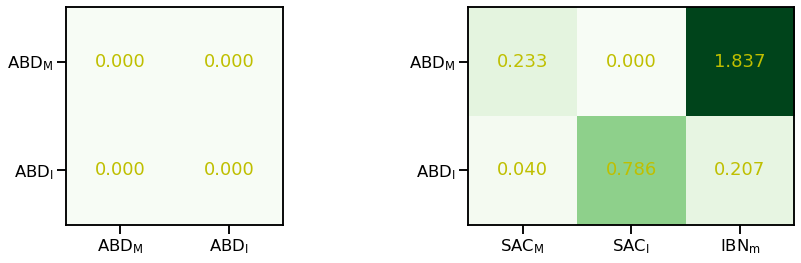

In [904]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$ABD_M$", "$ABD_I$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()